# Import library

In [1]:
import pandas as pd
import tensorflow as tf
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn import preprocessing
from tensorflow.keras.models import *
from tensorflow.keras.layers import *
from tensorflow.keras.callbacks import *
from tensorflow.keras.optimizers import Adam
from functools import partial
from sklearn.metrics import classification_report
from time import time
import gc

In [2]:
physical_devices = tf.config.experimental.list_physical_devices('GPU')
print(physical_devices)
tf.config.experimental.set_memory_growth(physical_devices[0], True)
!nvidia-smi -L

[PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')]
GPU 0: NVIDIA GeForce RTX 2080 Ti (UUID: GPU-b40ca8d0-abdc-cfcd-8b26-ab0e1c48f616)


# Load Data

In [3]:
train_path = "E:/Old data/CTU13+PeerRush/dnn_input/1-1/CTU13_all_training_shuf"
test_path = "E:/Old data/CTU13+PeerRush/dnn_input/1-1/CTU13_all_testing_shuf"
train_data = open(test_path, 'r')
test_data = open(train_path, 'r')

In [4]:
def make_dataframe(data):
    '''
    the function reads in raw data and outputs dataframe format
    '''
    output = []
    for line in data:
        cols = line.split(',')
        cols[-1] = cols[-1].rstrip()         #remove \n
        output.append(cols)
    print("Number of sessions: ", len(output))       
    print("Number of features: ", len(output[0])-2)   
    output = pd.DataFrame(output, columns = ["IP pair", "f1", "f2", "f3", "f4", "f5", "f6", "f7", "f8", "f9",
                                      "f10", "f11", "f12", "f13", "f14", "label"])
    return output

# Combine and Shuffle

In [5]:
df_train = make_dataframe(train_data)
df_test = make_dataframe(test_data)
df_combine = pd.concat([df_train, df_test])

Number of sessions:  4582
Number of features:  14
Number of sessions:  1472
Number of features:  14


In [6]:
df_combine

,IP pair,f1,f2,f3,f4,f5,f6,f7,f8,f9,f10,f11,f12,f13,f14,label
0,147.32.84.191>81.167.10.130,2,652,326,326,326.0,131,131,131,131.0,783,326,261.0,91.92388,0.200920245398773,0
1,147.32.84.191>121.54.32.135,4,504,126,126,126.0,0,-1,-1,-1.0,504,126,126.0,0.0,0.0,1
2,147.32.84.192>110.18.224.196,4,360,90,90,90.0,0,-1,-1,-1.0,360,90,90.0,0.0,0.0,1
3,147.32.84.165>211.140.199.130,4,444,111,111,111.0,221,110,110,110.0,665,111,110.66667,0.4714,0.49774774774774777,0
4,147.32.84.191>84.52.163.247,8,2328,291,291,291.0,632,158,158,158.0,2960,291,246.66667,62.6968,0.27147766323024053,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1467,147.32.84.165>60.160.108.251,2,150,75,75,75.0,76,76,76,76.0,226,76,75.33333,0.4714,0.5066666666666667,1
1468,147.32.84.192>89.208.180.60,24,2240,93,93,93.0,18650,981,981,981.0,20890,981,485.37209,440.98816,8.325892857142858,1
1469,147.32.84.192>94.251.103.230,2,252,126,126,126.0,319,319,319,319.0,571,319,190.33333,90.98107,1.2658730158730158,1
1470,147.32.84.191>195.138.217.171,2,652,326,326,326.0,131,131,131,131.0,783,326,261.0,91.92388,0.200920245398773,0


In [7]:
def normalize_(df):
    x = df.values #returns a numpy array
    min_max_scaler = preprocessing.MinMaxScaler()
    x_scaled = min_max_scaler.fit_transform(x)
    df = pd.DataFrame(x_scaled)
    return df
df_combine.iloc[:, 1:-1] = normalize_(df_combine.iloc[:, 1:-1])

In [8]:
df_combine

,IP pair,f1,f2,f3,f4,f5,f6,f7,f8,f9,f10,f11,f12,f13,f14,label
0,147.32.84.191>81.167.10.130,0.000105,0.000058,0.075249,0.075249,0.075249,0.000016,0.041045,0.041045,0.041045,0.00007,0.075249,0.220868,0.063509,0.001239,0
1,147.32.84.191>121.54.32.135,0.000314,0.000044,0.0215,0.0215,0.0215,0.0,0.0,0.0,0.0,0.000043,0.0215,0.082183,0.0,0.0,1
2,147.32.84.192>110.18.224.196,0.000314,0.00003,0.011825,0.011825,0.011825,0.0,0.0,0.0,0.0,0.000029,0.011825,0.045201,0.0,0.0,1
3,147.32.84.165>211.140.199.130,0.000314,0.000038,0.017468,0.017468,0.017468,0.000028,0.034515,0.034515,0.034515,0.000058,0.017468,0.066432,0.000326,0.00307,0
4,147.32.84.191>84.52.163.247,0.000733,0.00022,0.065843,0.065843,0.065843,0.000079,0.04944,0.04944,0.04944,0.000277,0.065843,0.206143,0.043317,0.001674,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1467,147.32.84.165>60.160.108.251,0.000105,0.00001,0.007794,0.007794,0.007794,0.00001,0.023943,0.023943,0.023943,0.000016,0.008062,0.030134,0.000326,0.003125,1
1468,147.32.84.192>89.208.180.60,0.002408,0.000212,0.012631,0.012631,0.012631,0.002341,0.305348,0.305348,0.305348,0.001989,0.251277,0.451363,0.304675,0.051354,1
1469,147.32.84.192>94.251.103.230,0.000105,0.00002,0.0215,0.0215,0.0215,0.00004,0.099502,0.099502,0.099502,0.000049,0.073367,0.148272,0.062858,0.007808,1
1470,147.32.84.191>195.138.217.171,0.000105,0.000058,0.075249,0.075249,0.075249,0.000016,0.041045,0.041045,0.041045,0.00007,0.075249,0.220868,0.063509,0.001239,0


In [9]:
df_train, df_test = train_test_split(df_combine, test_size=0.95, random_state = 42, shuffle = True)

# Proportion of Malicious

In [10]:
# proportion of benign and malicious
def get_proportion():
    n_0, n_1 = 0, 0
    for i in df_combine['label']:
        if i == '0':
            n_0 += 1
        else:
            n_1 += 1
    print("Malicious proportion: ", n_1 / (n_0+n_1) * 100, " %")
get_proportion()

Malicious proportion:  24.297984803435746  %


# Data Preparation 

In [11]:
train_y = np.array(df_train['label']).astype(np.float)
train_x = np.array(df_train.iloc[:, 1:-1]).astype(np.float)
test_y = np.array(df_test['label']).astype(np.float)
test_x = np.array(df_test.iloc[:, 1:-1]).astype(np.float)
print("train x: ", train_x.shape)
print("train y: ", train_y.shape)
print("test x: ", test_x.shape)
print("test y: ", test_y.shape)

train x:  (302, 14)
train y:  (302,)
test x:  (5752, 14)
test y:  (5752,)


# Model Construct

In [12]:
def dnn_model(train_x, output_class = 2, neurons = 4096, drop_rate = 0.4, weights = None):
    
    '''
    1. 6 fully connect layers with 4096 neurons as default
    2. set dropout layers at last 3 hidden layers
    3. load weights if weight not none
    '''
    
    input_features = train_x.shape[1]
    RegularizedDense = partial(Dense, 
                              activation = 'relu', 
                              kernel_initializer = 'he_normal')
    model = Sequential([
        Input(shape = (input_features, )),
        RegularizedDense(neurons),
        RegularizedDense(neurons),
        RegularizedDense(neurons),
        RegularizedDense(neurons),
        Dropout(drop_rate),
        RegularizedDense(neurons),
        Dropout(drop_rate),
        RegularizedDense(neurons),
        Dropout(drop_rate),
        RegularizedDense(output_class, activation = 'softmax')
    ])
    if weights:
        model.load_weights(weights)
    return model

In [13]:
def train_model(model, train_x, train_y,
                lr, epochs, batch, early_p = 30,
                lr_p = 9, min_lr = 1e-7, lr_factor = 0.1):
    
    '''
    1. validation data is always set to 0.2 of training data
    2. earlystopping and learning rate scheduler to improve accuracy
    
    '''
    
    callback = EarlyStopping(monitor='val_accuracy', patience=early_p, restore_best_weights=True)
    reduce_lr = ReduceLROnPlateau(monitor='val_accuracy', factor=lr_factor, patience=lr_p, verbose=1, min_lr=min_lr)
    opt = Adam(learning_rate=lr)
    model.compile(optimizer=opt, loss='sparse_categorical_crossentropy', metrics=['accuracy'])
    history = model.fit(train_x, train_y,
                        callbacks=[callback, reduce_lr],
                        shuffle=True,
                        epochs=epochs,
                        batch_size = batch,
                        validation_split=0.2)
    return history

# Model Summary

In [14]:
model = dnn_model(train_x)
model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense (Dense)                (None, 4096)              61440     
_________________________________________________________________
dense_1 (Dense)              (None, 4096)              16781312  
_________________________________________________________________
dense_2 (Dense)              (None, 4096)              16781312  
_________________________________________________________________
dense_3 (Dense)              (None, 4096)              16781312  
_________________________________________________________________
dropout (Dropout)            (None, 4096)              0         
_________________________________________________________________
dense_4 (Dense)              (None, 4096)              16781312  
_________________________________________________________________
dropout_1 (Dropout)          (None, 4096)              0

# Train Model

In [15]:
# HyperParameters
batch_size = 16
epochs = 200
learning_rate = 1e-3
early_patience = 15
learning_rate_patience = 2
lr_factor = 0.3
min_learning_rate = 5e-6

In [16]:
t1 = time()
history = train_model(model, train_x, train_y, lr = learning_rate,
                      epochs = epochs, batch = batch_size, 
                      early_p = early_patience, lr_p = learning_rate_patience, 
                      min_lr = min_learning_rate, lr_factor = lr_factor)
t2 = time()
print("Total Execution Time: ",t2-t1)

Epoch 1/200
16/16 [==============================] - 4s 88ms/step - loss: 4.8615 - accuracy: 0.6827 - val_loss: 0.2682 - val_accuracy: 0.8852
Epoch 2/200
16/16 [==============================] - 1s 72ms/step - loss: 0.4069 - accuracy: 0.8171 - val_loss: 0.3014 - val_accuracy: 0.8852
Epoch 3/200
16/16 [==============================] - 1s 70ms/step - loss: 0.6377 - accuracy: 0.8987 - val_loss: 0.1564 - val_accuracy: 0.9016
Epoch 4/200
16/16 [==============================] - 0s 15ms/step - loss: 0.2927 - accuracy: 0.8854 - val_loss: 0.4007 - val_accuracy: 0.8852
Epoch 5/200
16/16 [==============================] - 0s 16ms/step - loss: 0.2794 - accuracy: 0.9003 - val_loss: 0.4692 - val_accuracy: 0.8852

Epoch 00005: ReduceLROnPlateau reducing learning rate to 0.0003000000142492354.
Epoch 6/200
16/16 [==============================] - 0s 15ms/step - loss: 0.3033 - accuracy: 0.8658 - val_loss: 0.1463 - val_accuracy: 0.9016
Epoch 7/200
16/16 [==============================] - 0s 15ms/step -

# Performance on test data

In [17]:
result = model.evaluate(test_x, test_y, verbose=2)
best_score = result[1]
print("Accuracy: ",best_score)
model.save_weights('./self_train_best_weights.h5')

180/180 - 0s - loss: 0.2548 - accuracy: 0.8634
Accuracy:  0.8633518815040588


# Plot

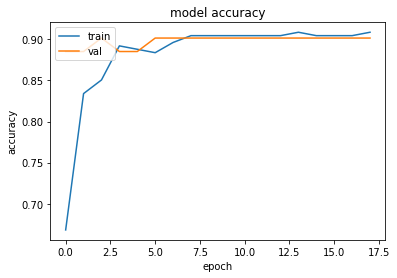

In [18]:
from matplotlib import pyplot as plt
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'val'], loc='upper left')
plt.show()

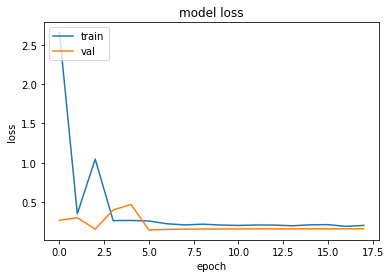

In [19]:
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'val'], loc='upper left')
plt.show()

# Classification Report

In [20]:
label_dict = ['Benign', 'Malicious']
predictions = model.predict(test_x)
y_pred = np.argmax(predictions, axis=-1)
print(classification_report(test_y, y_pred, target_names = label_dict))

              precision    recall  f1-score   support

      Benign       0.87      0.96      0.91      4354
   Malicious       0.81      0.57      0.67      1398

    accuracy                           0.86      5752
   macro avg       0.84      0.76      0.79      5752
weighted avg       0.86      0.86      0.85      5752



# Confident Threshold

In [21]:
unconfident, confident = 0, 0
threshold = 0.99
for softmax in predictions:
    if max(softmax) > threshold:
        confident += 1
    else:
        unconfident += 1
print(predictions.shape)
print("Confident Samples: ",confident)
print("Unconfident Samples: ",unconfident)

(5752, 2)
Confident Samples:  2994
Unconfident Samples:  2758


# Self-Training

In [22]:
def self_train(model, test_x, test_y,
               train_x, train_y, self_train_epoch, model_epoch,
               BATCH, lr_, best_score, proportion):
    
    # Pseudo label
    # Tune model with pseudo label and training data
    
    assert(len(proportion) == self_train_epoch)
    
    for i in range(self_train_epoch):
        print('Predict Pseudo labels...\n')
        predictions = model.predict(test_x, verbose=1, batch_size = BATCH*4) 
        
        # (data_len, 1) -> get the biggest confidence of all samples
        confidence = np.amax(predictions, axis=1)
        confidence = sorted(confidence, reverse = True)
        
        # proportion of the index
        #ind = min(len(test_x)-1, int(len(test_x) * ((i+1)/self_train_epoch)))
        ind =  min(len(test_x)-1, int(len(test_x) * proportion[i]))
        threshold = confidence[ind]
        print("threshold:", threshold)
        
        x, y, act_y = [],[],[]
        for ind, data in enumerate(test_x):
            if max(predictions[ind]) >= threshold:
                x.append(data)
                y.append(np.argmax(predictions[ind]))
                act_y.append(test_y[ind])
        pselabel_x = np.array(x)
        pselabel_y = np.array(y)
        err = 0
        for a,b in zip(y, act_y):
            if a != b:
                err += 1
                
        print("Pseudo label accuracy: ", (len(x) -err)/len(x))
        del x
        del y 
        del act_y
        
        # check if class disapeear at pseudo label examples
        if tf.keras.utils.to_categorical(pselabel_y).shape[1] != 2:    
            break

        # combine pseudo label & ground truth label
        combine_x = np.concatenate((pselabel_x, train_x), axis=0)
        combine_y = np.concatenate((pselabel_y, train_y), axis=0)
        print("Combine data shape: ",combine_x.shape)
        print("Combine label shape: ",combine_y.shape,"\n")
        
        del pselabel_x
        del pselabel_y
        
        print('Tune model using pseudo-labeled data & training data...\n')
        model.compile(optimizer=Adam(lr=lr_), 
                  loss='sparse_categorical_crossentropy', 
                  metrics=['accuracy'])
        
        model.fit(combine_x, combine_y, 
                            epochs =  model_epoch, 
                            verbose = 2,
                            batch_size = BATCH, shuffle = True)
        del combine_x
        del combine_y
        
        print('Evaluate model...\n')
        score = model.evaluate(test_x, test_y, verbose = 2)
        if score[1] > best_score:
            model.save_weights('./self_train_best_weights.h5')
            best_score = score[1]
        else:
            model.load_weights('./self_train_best_weights.h5')
            lr_ *= 0.3
            if lr_ < 1e-7:
                lr_ = 1e-5
                print("learning rate restart to: ", lr_)
            else:
                print("learning rate reduce to: ", lr_)
        gc.collect()
    return best_score, model

In [23]:
proportion = [0.5, 0.55, 0.6, 0.7, 0.75, 0.8, 0.85, 
              0.9, 0.93, 0.94, 0.95, 0.96, 0.96, 0.97, 0.97, 0.98, 0.98, 0.99, 0.99, 1]
best_score, model = self_train(model, test_x, test_y,
                               train_x, train_y, self_train_epoch = 20, model_epoch = 1,
                               BATCH = 16, lr_ = 1e-4, best_score = best_score,
                               proportion = proportion)

Predict Pseudo labels...

90/90 [==============================] - 0s 2ms/step
threshold: 0.99570614
Pseudo label accuracy:  0.9989579715178881
Combine data shape:  (3181, 14)
Combine label shape:  (3181,) 

Tune model using pseudo-labeled data & training data...

199/199 - 6s - loss: 0.0266 - accuracy: 0.9903
Evaluate model...

180/180 - 2s - loss: 0.2717 - accuracy: 0.9404
Predict Pseudo labels...

90/90 [==============================] - 1s 10ms/step
threshold: 0.9995857
Pseudo label accuracy:  0.9924146649810367
Combine data shape:  (3466, 14)
Combine label shape:  (3466,) 

Tune model using pseudo-labeled data & training data...

217/217 - 6s - loss: 0.0333 - accuracy: 0.9902
Evaluate model...

180/180 - 2s - loss: 0.2581 - accuracy: 0.8957
learning rate reduce to:  3e-05
Predict Pseudo labels...

90/90 [==============================] - 1s 11ms/step
threshold: 0.9987418
Pseudo label accuracy:  0.9873878923766816
Combine data shape:  (3870, 14)
Combine label shape:  (3870,) 

Tune

In [24]:
print("ACC after Self Training: ", best_score)

ACC after Self Training:  0.9408901333808899
